# DeepAR Demo

In [1]:
import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import pandas as pd
import torch

from pytorch_forecasting import Baseline, DeepAR, TimeSeriesDataSet
from pytorch_forecasting.data import NaNLabelEncoder
from pytorch_forecasting.data.examples import generate_ar_data
from pytorch_forecasting.metrics import MAE, SMAPE, MultivariateNormalDistributionLoss, NormalDistributionLoss

c:\Anaconda3\envs\forecast\lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


In [2]:
data = generate_ar_data(seasonality=10.0, timesteps=400, n_series=100, seed=42)
data

,series,time_idx,value
0,0,0,-0.000000
1,0,1,-0.046501
2,0,2,-0.097796
3,0,3,-0.144397
4,0,4,-0.177954
...,...,...,...
39995,99,395,-5.587069
39996,99,396,-4.986342
39997,99,397,-5.630228
39998,99,398,-5.745145


In [3]:
data["static"] = 2
data["date"] = pd.Timestamp("2020-01-01") + pd.to_timedelta(data.time_idx, "D")
data.head()

,series,time_idx,value,static,date
0,0,0,-0.000000,2,2020-01-01
1,0,1,-0.046501,2,2020-01-02
2,0,2,-0.097796,2,2020-01-03
3,0,3,-0.144397,2,2020-01-04
4,0,4,-0.177954,2,2020-01-05


In [4]:
data.dtypes

series               int64
time_idx             int64
value              float64
static               int64
date        datetime64[ns]
dtype: object

In [5]:
data = data.astype({"series": "str"})
data.dtypes

series              object
time_idx             int64
value              float64
static               int64
date        datetime64[ns]
dtype: object

In [6]:
data

,series,time_idx,value,static,date
0,0,0,-0.000000,2,2020-01-01
1,0,1,-0.046501,2,2020-01-02
2,0,2,-0.097796,2,2020-01-03
3,0,3,-0.144397,2,2020-01-04
4,0,4,-0.177954,2,2020-01-05
...,...,...,...,...,...
39995,99,395,-5.587069,2,2021-01-30
39996,99,396,-4.986342,2,2021-01-31
39997,99,397,-5.630228,2,2021-02-01
39998,99,398,-5.745145,2,2021-02-02


In [7]:
# create dataset and dataloaders
max_encoder_length = 60
max_prediction_length = 20

training_cutoff = data["time_idx"].max() - max_prediction_length

context_length = max_encoder_length
prediction_length = max_prediction_length

training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="value",
    categorical_encoders={"series": NaNLabelEncoder().fit(data.series)},
    group_ids=["series"],
    static_categoricals=[
        "series"
    ],  # as we plan to forecast correlations, it is important to use series characteristics (e.g. a series identifier)
    time_varying_unknown_reals=["value"],
    max_encoder_length=context_length,
    max_prediction_length=prediction_length,
)

validation = TimeSeriesDataSet.from_dataset(training, data, min_prediction_idx=training_cutoff + 1)

In [8]:
batch_size = 512
# synchronize samples in each batch over time - only necessary for DeepVAR, not for DeepAR
train_dataloader = training.to_dataloader(
    train=True, batch_size=batch_size, num_workers=0, 
    # batch_sampler="synchronized",   # for DEEPVAR
)
val_dataloader = validation.to_dataloader(
    train=False, batch_size=batch_size, num_workers=0, 
    # batch_sampler="synchronized",   # for DEEPVAR
)

In [9]:
len(train_dataloader)

58

In [10]:
len(val_dataloader)

1

In [11]:
# calculate baseline absolute error
baseline_predictions = Baseline().predict(val_dataloader, trainer_kwargs=dict(accelerator="gpu"), return_y=True)
SMAPE()(baseline_predictions.output, baseline_predictions.y[0].reshape(baseline_predictions.output.shape))

c:\Anaconda3\envs\forecast\lib\site-packages\lightning\pytorch\utilities\parsing.py:198: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
c:\Anaconda3\envs\forecast\lib\site-packages\lightning\pytorch\utilities\parsing.py:198: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CU

tensor(0.5462, device='cuda:0')

In [12]:
pl.seed_everything(42)
import pytorch_forecasting as ptf

trainer = pl.Trainer(accelerator="gpu", gradient_clip_val=1e-1)
net = DeepAR.from_dataset(
    training,
    learning_rate=3e-2,
    hidden_size=30,
    rnn_layers=2,
    loss=NormalDistributionLoss(),       # MultivariateNormalDistributionLoss(rank=30),  # change DEEPAR to DEEPVAR by changing the loss to multivariate (correlation between the series). 
    optimizer="Adam",
)

Seed set to 42
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Anaconda3\envs\forecast\lib\site-packages\lightning\pytorch\utilities\parsing.py:198: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
c:\Anaconda3\envs\forecast\lib\site-packages\lightning\pytorch\utilities\parsing.py:198: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


c:\Anaconda3\envs\forecast\lib\site-packages\lightning\pytorch\loops\utilities.py:72: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
c:\Anaconda3\envs\forecast\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
c:\Anaconda3\envs\forecast\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.015848931924611138
Restoring states from the checkpoint path at d:\jupyter-notebook\Kaggle\m5-forecasting-accuracy\m5-kedro-mlflow\notebooks\.lr_find_dc8f6892-4238-46b2-8b01-625802e3a9db.ckpt
Restored all states from the checkpoint at d:\jupyter-notebook\Kaggle\m5-forecasting-accuracy\m5-kedro-mlflow\notebooks\.lr_find_dc8f6892-4238-46b2-8b01-625802e3a9db.ckpt


suggested learning rate: 0.015848931924611138


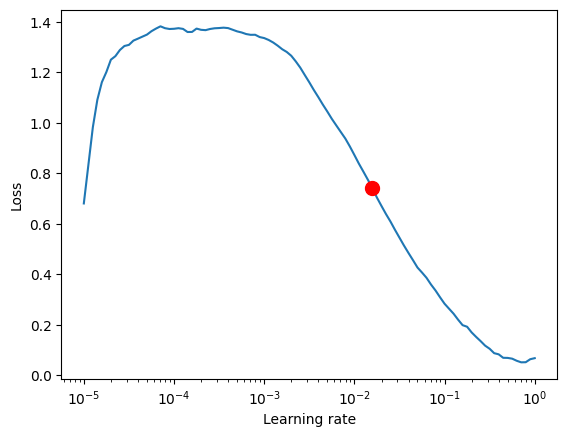

C:\Users\LAMRA2\AppData\Local\Temp\ipykernel_28636\2406202609.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


In [13]:
# find optimal learning rate
from lightning.pytorch.tuner import Tuner

res = Tuner(trainer).lr_find(
    net,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    min_lr=1e-5,
    max_lr=1e0,
    early_stop_threshold=100,
)
print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()
net.hparams.learning_rate = res.suggestion()

In [14]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
trainer = pl.Trainer(
    max_epochs=30,
    accelerator="gpu",
    enable_model_summary=True,
    gradient_clip_val=0.1,
    callbacks=[early_stop_callback],
    limit_train_batches=50,
    enable_checkpointing=True,
)

# net = DeepAR.from_dataset(
#     training,
#     learning_rate=1e-2,
#     log_interval=10,
#     log_val_interval=1,
#     hidden_size=30,
#     rnn_layers=2,
#     optimizer="Adam",
#     loss=MultivariateNormalDistributionLoss(rank=30),
# )

trainer.fit(
    net,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name                   | Type                   | Params
------------------------------------------------------------------
0 | loss                   | NormalDistributionLoss | 0     
1 | logging_metrics        | ModuleList             | 0     
2 | embeddings             | MultiEmbedding         | 2.1 K 
3 | rnn                    | LSTM                   | 13.9 K
4 | distribution_projector | Linear                 | 62    
------------------------------------------------------------------
16.1 K    Trainable par

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [15]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_model = DeepAR.load_from_checkpoint(best_model_path)

In [16]:
# best_model = net
predictions = best_model.predict(val_dataloader, trainer_kwargs=dict(accelerator="gpu"), return_y=True)
SMAPE()(predictions.output, predictions.y[0].reshape(predictions.output.shape))

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


tensor(0.1580, device='cuda:0')

In [17]:
raw_predictions = net.predict(
    val_dataloader, mode="raw", return_x=True, n_samples=100, trainer_kwargs=dict(accelerator="gpu")
)

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


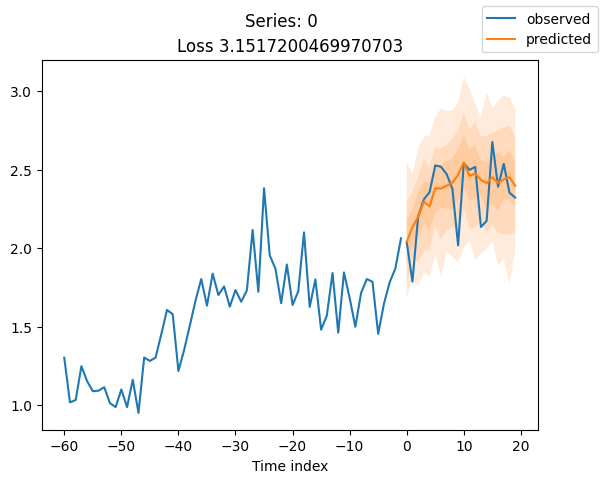

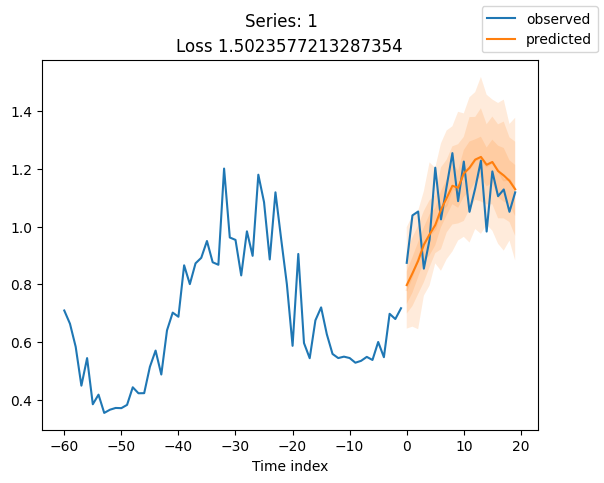

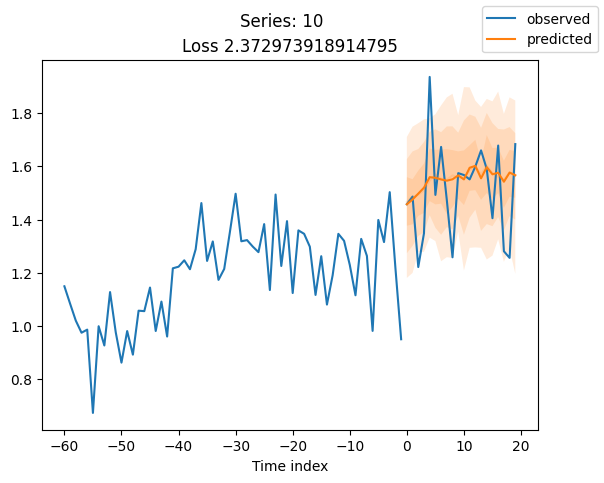

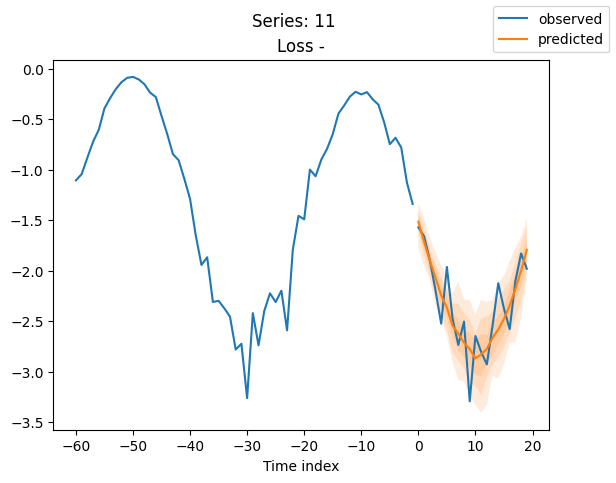

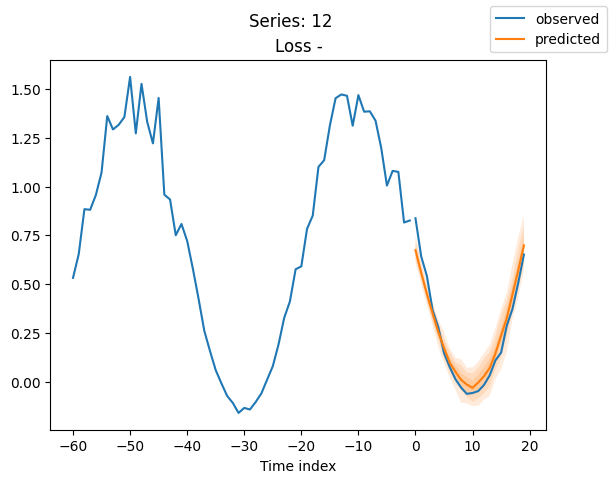

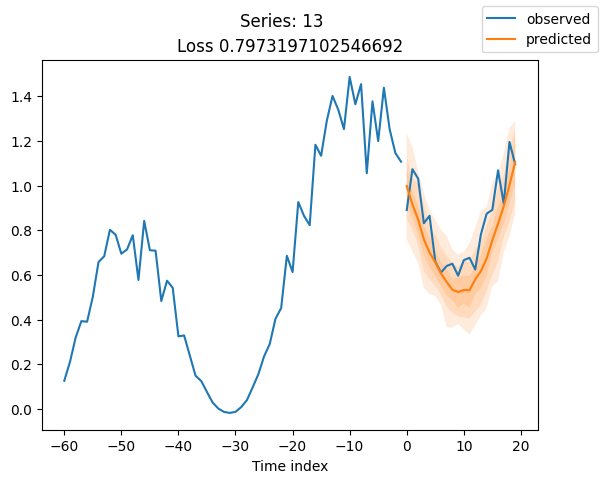

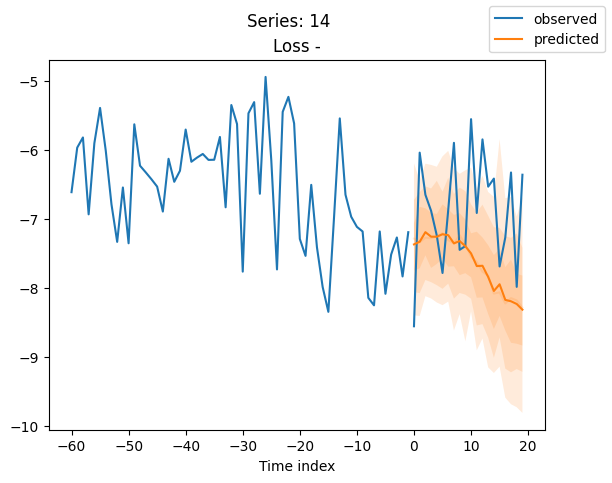

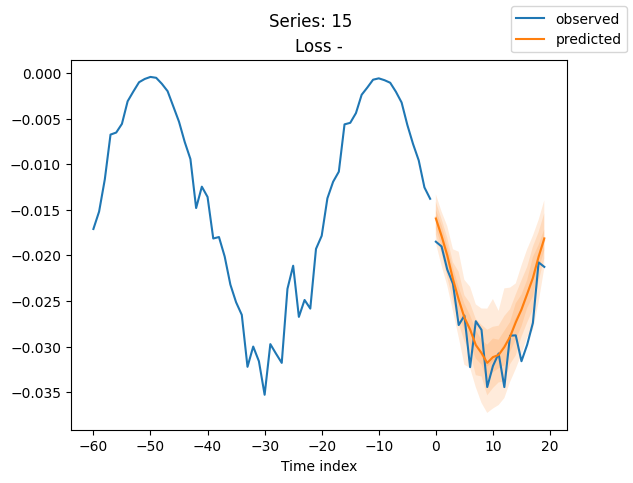

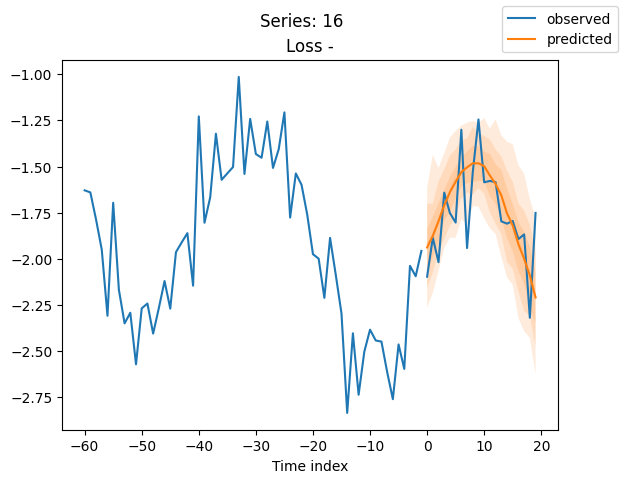

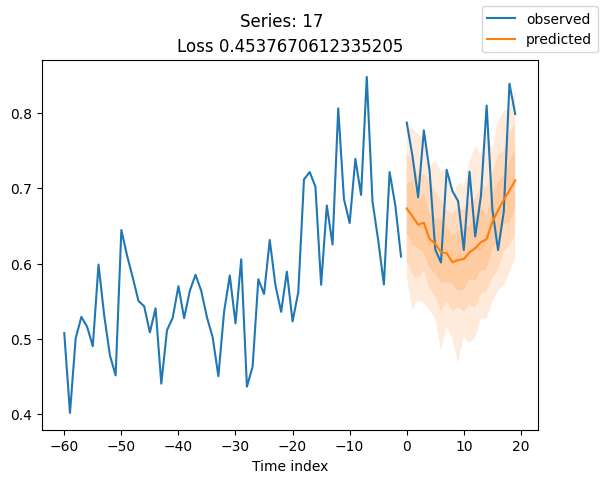

In [18]:
series = validation.x_to_index(raw_predictions.x)["series"]
for idx in range(10):  # plot 10 examples
    best_model.plot_prediction(raw_predictions.x, raw_predictions.output, idx=idx, add_loss_to_title=True)
    plt.suptitle(f"Series: {series.iloc[idx]}")

In [19]:
# Only for DEEPVAR
cov_matrix = best_model.loss.map_x_to_distribution(
    best_model.predict(
        val_dataloader, mode=("raw", "prediction"), n_samples=None, trainer_kwargs=dict(accelerator="cpu")
    )
).base_dist.covariance_matrix.mean(0)

# normalize the covariance matrix diagnoal to 1.0
correlation_matrix = cov_matrix / torch.sqrt(torch.diag(cov_matrix)[None] * torch.diag(cov_matrix)[None].T)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(correlation_matrix, cmap="bwr")

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Anaconda3\envs\forecast\lib\site-packages\lightning\pytorch\trainer\setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


AttributeError: 'Normal' object has no attribute 'covariance_matrix'

(array([ 702.,  816.,  848., 1176., 1604., 1626., 1014.,  842.,  706.,
         566.]),
 array([-0.89460713, -0.70759976, -0.52059239, -0.33358505, -0.14657769,
         0.04042968,  0.22743705,  0.41444442,  0.60145175,  0.78845912,
         0.97546649]),
 <BarContainer object of 10 artists>)

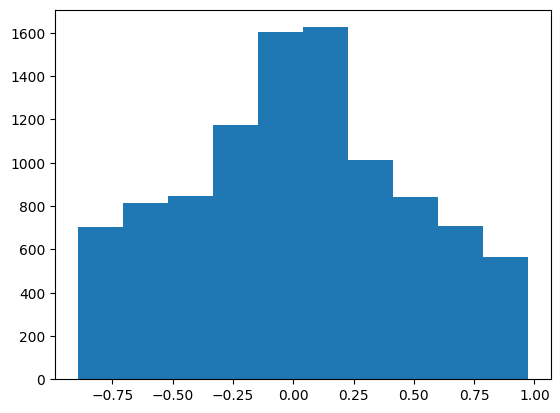

In [ ]:
# Only for DEEPVAR
# distribution of off-diagonal correlations
plt.hist(correlation_matrix[correlation_matrix < 1].numpy())